---
title: "2021 Thomas Fire Air Quality Index and Fire Scar Analysis"
description: "An analysis of Santa Barbara’s 2021 Thomas Fire, visualizing the scar the fire left. As well as analyzing the air quaility level at the time."
author: 
  - name: Hazel Vaquero
    url: https://hazelvaq.github.io/ 
    #orcid: 0
    affiliation: MEDS
    affiliation-url: https://bren.ucsb.edu/masters-programs/master-environmental-data-science/academics-meds
published: 12-13-2023
categories: [Quarto, MEDS, Python]
citation: 
  url: https://hazelvaq.github.io/blog/2023-12-23-SB-Thomas-Fire/
#image: 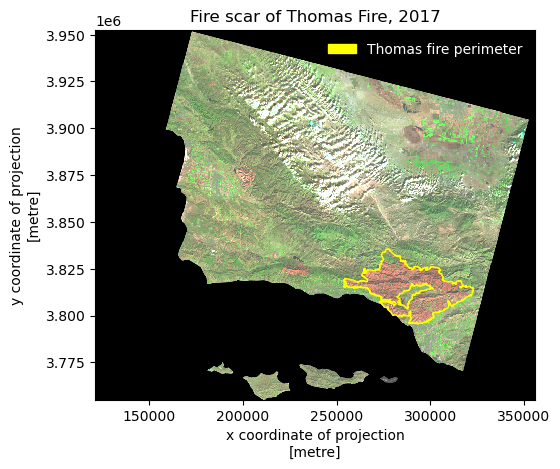
draft: false
---

## About
In this notebook I analyzed the affects of the Santa Barbara 2017 Thomas Fire. I created a time series showing the 
Averaged Air Quaility Index(AQI) from 2017 to 2018. As well as creating a raster map of the scar caused by the Thomas Fire.  


Additional information can be found at my repository: https://github.com/hazelvaq/Santa-Barbara-Thomas-Fire.git

## Datasets

**[EPA's Air Quality Data Collected at Outdoor Monitor Stations](https://www.epa.gov/outdoor-air-quality-data)**

The first dataset contains information on daily AQI readings across the United States. AQI readings are an indicator that allow the public to understand how polluted their air is. Higher levels in AQI translate to more pollution present in the atmosphere. 

This dataset has been download from the [EPA's Air Quality System (AQS)](https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI).

Additional information and metadata for this datset is available in the [Airdata Download Files Documentation](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html)

**[California Fire Perimeter](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about)**

As noted by The State of California and the Department of Forestry and Fire Protection this data provides a spatial distribution of the past large fires in California. But, this data is in no way a complete potrayal of the past fires. 

This shapefile has been downloaded from [California Govt State Geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about). 

Additional data can be found in the [Fire Perimeters Description](https://www.arcgis.com/sharing/rest/content/items/e3802d2abf8741a187e73a9db49d68fe/info/metadata/metadata.xml?format=default&output=html)

**[Landsat Data](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)**

This is a NetCDF file of a raster of Santa Barbara visualizing Santa Barbara. The data was accessed and pre-processed in the Microsoft Planetary Computer. The raster consists of three dimensions: x,y, band. It also contains the following data variables: red, green, blue, nir08(near infared), swir22(short wave). 

Additional information regarding the Landsat bands can be found at the following [USGS](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites) [websites](https://www.usgs.gov/media/images/common-landsat-band-combinations).  

## Final Output

The final visualization for this notebook are the following figures:

<ins>Santa Barbara AQI 2017-2018<ins>
    
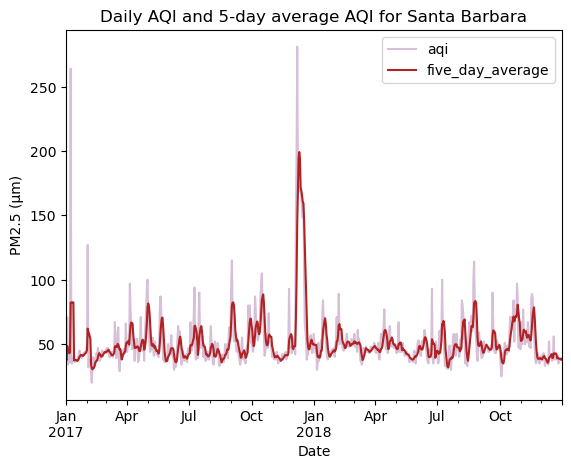

<ins>Santa Barbara Thomas Fire 2017<ins>    

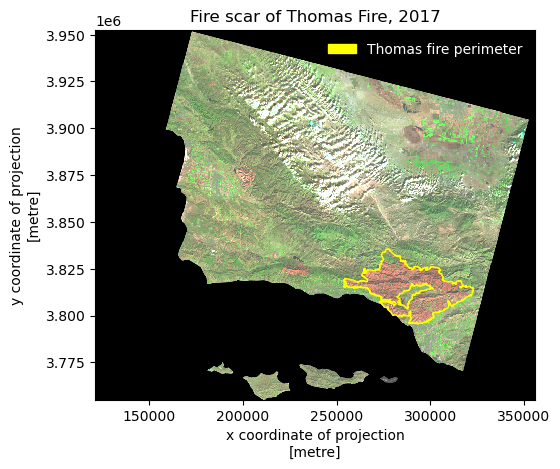


## Geographic Context

For context, let see where Santa Barbara county is relative to California

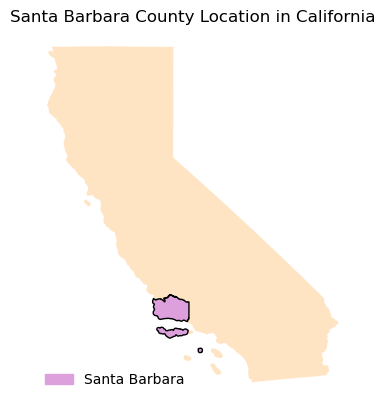

## Import Libraries

Import necessary libraries for data wrangling and geospatial analysis

In [1]:
# read in pandas
import pandas as pd
# import matplotlib for colors
import matplotlib.pyplot as plt 

# import libraries and functions here
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

## for geospatial analysis
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

## Import Data
Import neccessary data.

In [2]:
# read in 2017 Daily AQI by County data
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")

# read in 2018 Daily AQI by County data
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")
                     # read in 2017 and 2018 Daily AQI by County data
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

# Import California wildfire data
wildfires = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp')
# Import Landsat
landsat = rioxr.open_rasterio(os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc'))

## Data Preparation

#### AQI

Before I can plot a time series of the daily AQI I need to prepare the data. I need to combine the two years(2017 and 2018) of AQI, clean the columns, and update the object types.

In [3]:
# "Glue" aqi_17 and aqi_18
aqi = pd.concat([aqi_17,aqi_18])

# Update column by making lower case and replace space with underscore
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# update date column to be datetime object
aqi = aqi.copy()
aqi.date = pd.to_datetime(aqi.date)

# Set date to indez
aqi = aqi.set_index("date")

#### Landsat Data Preparation 

The landsat data contains an extra dimension, `band`, that is not necessary and can cause some issues when plotting. I will remove this dimension. 

In [4]:
# remove length 1 dimension (band)
landsat = landsat.squeeze()

# remove coordinates associated to band
landsat = landsat.drop('band')

#### Wildfire Data Preparation

Lets explore our Wildfire shapefile, update the column names, and update the CRS to the landsat CRS.

In [5]:
# Make column names lowercase
wildfires.columns = wildfires.columns.str.lower()

#Update wildfire CRS to match Landsar CRS
wildfires = wildfires.to_crs(landsat.rio.crs)

## Data Selection

#### Santa Barbara 

Our current dataframe includes all Counties in the United States. But, we are only interested in Santa Barbara. Let's filter our dataframe to Santa Barbara County and drop unecessary columns. 

In [6]:
# Select Santa Barbara
aqi_sb = aqi[aqi.county_name == "Santa Barbara"]

# Check that we only filtered for Santa Barbara by unique county_names
aqi_sb.county_name.unique()

# remove state_name, county_name, state_code and county_code columns
aqi_sb = aqi_sb.drop(columns = ['state_name','county_name','state_code','county_code'])

#### Wildfire

Our interest is only on the Thomas fire, let us filter our data to only include it.

In [7]:
# We are interested in the THOMAS FIRE
# Filter dataset to THOMAS FIRE
wildfires = wildfires[wildfires.fire_name == 'THOMAS']

## Data Visualization

### Time Series

To calculate the trend of AQI values we conduct a 5-day rolling average.

In [8]:
# Create a new column with mean AQI over a 5-day rolling average.
#aqi_sb["five_day_average"] = aqi_sb.aqi.rolling("5D").mean()

aqi_sb["five_day_average"] = aqi_sb.aqi.rolling("5D").mean()

Now we can make a line plot of our time series! Let us compare both the daily AQI and 5-day moving average.

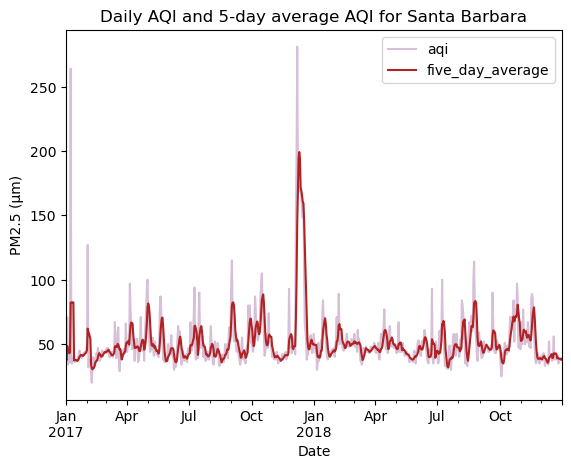

In [9]:
# define colors for plot
colors = ['thistle','firebrick']

# ------ Plot figure -----------------------------------------------------------------
# line plot of daily AQI and the 5-day average 
aqi_sb.plot(y = ['aqi','five_day_average'], # setting y as AQI and 5-day average AQI
           xlabel = "Date", # x-axis label
           ylabel = "PM2.5 (μm)", #y-axis label
           title = "Daily AQI and 5-day average AQI for Santa Barbara", # title 
           color = colors) #setting colors for lines

# -----Save Figure-----------------------------------------------------------------------
plt.savefig('images/sb_county_aqi.png',bbox_inches = 'tight',dpi = 100)
plt.show()

We see that Daily AQI peaks around December which is on par with when the Thomas Fire (December 4 - March 22) occured. An interesting thing to note is that the peak AQI was reached right at the start of the fire and eventually returned to the average AQI after January, even though the fire did not stop till March.

### Map of Fire Scar

I can now map the Thomas Fire scar on top of the Santa Barbara raster. 

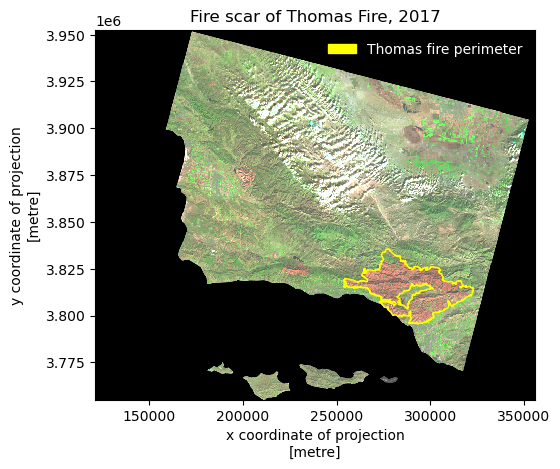

In [12]:
# Plot Wildfire and Landsat data together
fig, ax = plt.subplots()

# ---Landsat Map------------------------------------------------------------------------------------------------------------
# Here we are plotting with false color image by plotting the short-waved infared (swir22), near-infared, and red variable
# False color imaging allows us to differentiate the Thomas fire scar from the rest of the Santa Barbara area
landsat[['swir22','nir08','red']].to_array().plot.imshow(ax=ax,robust = True)
ax.set_facecolor('white')

#---Thomas Fire Layer-------------------------------------------------------------------------------------------------------
wildfires.plot(ax=ax, color = 'none', edgecolor = "yellow", linewidth = 1)
wildfires_patch = mpatches.Patch(color = 'yellow',
                                label = 'Thomas fire perimeter')

# ---Legend-----------------------------------------------------------------------------------------------------------------
plt.title("Fire scar of Thomas Fire, 2017") # title
ax.legend(handles = [wildfires_patch], frameon = False, loc = "upper right", labelcolor = "white")

# ------Save Image----------------------------------------------------------------------------------------------------------
plt.savefig('images/sb_thomas_fire_2017.png',bbox_inches = 'tight',dpi = 100)
plt.show() 


Based on the map we can see that Thomas Fire heavily affected Ventura and Ojai. 

*Code for making Geographic context*

In [ ]:
{
    "tags": [
        "hide-cell",
    ]
}

#--------- Import California boundary -----------------------------------------
california = gpd.read_file("data/california_boundary/CA_State_TIGER2016.shp")
cali_counties = gpd.read_file("data/california_counties_boundaries/CA_Counties_TIGER2016.shp")

# -------Filter to Santa Barbara ----------------------------------------------
santa_barbara = cali_counties[cali_counties.NAME == "Santa Barbara"]
# ---------Create Map----------------------------------------------------------
fig, ax = plt.subplots()
ax.axis('off')

ax.set_title("Santa Barbara County Location in California")

california.plot(ax=ax,color = 'bisque')
santa_barbara.plot(ax=ax, color = 'plum', edgecolor = "black")
sb_patch = mpatches.Patch(color = "plum",
                         label = 'Santa Barbara')
ax.legend(handles = [sb_patch], frameon = False, loc = "lower left", labelcolor = "black")

plt.savefig('../Santa-Barbara-Thomas-Fire/images/sb_ca.png',bbox_inches = 'tight',dpi = 100)
